In [1]:
import gym
import numpy as np
import torch

from stable_baselines3 import SAC, PPO, HerReplayBuffer
from stable_baselines3.common.buffers import DictReplayBuffer
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.monitor import Monitor

from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

import numpy as np
import gym

# from newLorenzEnvICs import Lorenz63Env
from newLorenzEnv import Lorenz63Env
from stable_baselines3 import PPO
import time 
import matplotlib.pyplot as plt
from typing import Callable

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = Lorenz63Env(integ_steps = 50)
        env.seed(seed + rank)
        return env
    set_random_seed(seed+ rank)
    return _init

In [3]:
num_cpu = 70  # Number of processes to use
# Create the vectorized environment
env = SubprocVecEnv([make_env('Lorenz', rank=i) for i in range(num_cpu)])
env = VecNormalize(env, norm_obs=True, norm_reward=False)

torch.backends.cudnn.benchmark = True

# for GAMMA in 0.05 0.1 0.2 0.3 0.8 0.9
# for BATCHSIZE in 1000 2000 4000
# for VFCOEFF in 0.7 0.8 0.9 0.95
# for MAXGRAD in 0.8 0.9 0.95

# neurons = [128]
# LR = [0.0001]
# Gamma =[0.05, 0.1, 0.2, 0.25, 0.3]
# BS = [500, 1000]
# Tstep = ['5000000']
# vf_coeff = [0.7, 0.8, 0.9]
# max_grad_norm = [0.8, 0.85, 0.9]

neurons = [128]
LR = [0.0001]
Gamma =[0.3]
BS = [500]
Tstep = ['5000000']
vf_coeff = [0.7]
max_grad_norm = [0.9]


In [4]:
# tSteps = '5000000'
for neuron in neurons:
    for lr in LR:
        for gamma in Gamma:
            for bs in BS:
                for tsteps in Tstep:
                    for max_grad_norms in max_grad_norm:
                        for vf in vf_coeff:
                            env = SubprocVecEnv([make_env('Lorenz', rank=i) for i in range(num_cpu)])
                            env = VecNormalize(env, norm_obs=True, norm_reward=False)

                            torch.backends.cudnn.benchmark = True

                            try:
                                model = PPO.load('trainedModels_assimSteps50_obsNosie1.0_vAction/'+'neurons'+str(neuron)+'_LR'+str(lr)+'_Gamma'+str(gamma)+'_BS'+str(bs)+'_totSteps'+tsteps+'_assimStep50_obsNosie1.0_maxgradnorm'+str(max_grad_norms)+'_vfcoeff'+str(vf)+'/'+'PPO_Lorenz63', env=env)
                            except:
                                model = PPO.load('trainedModels_assimSteps50_obsNosie1.0_vAction/'+'neurons'+str(neuron)+'_LR'+str(lr)+'_Gamma'+str(gamma)+'_BS'+str(bs)+'_totSteps'+tsteps+'_assimStep50_obsNosie1.0_maxgradnorm'+str(max_grad_norms)+'_vfcoeff'+str(vf)+'/'+'best_model.zip', env=env)
                            obs = env.reset()

                            solution = []
                            ref_soln = []
                            rewards_ = []
                            observations = []
                            acts = []

                            for _ in range(int(1000)):
                                action, _states = model.predict(obs, deterministic=False)
                                obs, rewards, dones, info = env.step(action)
                                trueObs = env.get_original_obs()
                                trueRew = env.get_original_reward()
                                trueRef = env.env_method("_get_ref", 1)

                                solution.append(trueObs)
                                ref_soln.append(trueRef)
                                rewards_.append(trueRew)
                                observations.append(obs)
                                acts.append(action)

                            sol2 = np.asarray(solution)
                            solR = np.asarray(ref_soln)

                            acts2 = np.asarray(acts)
                            observations2 = np.asarray(observations)

                            
                            counter = 0
                            x = np.zeros(int(50000))
                            y = np.zeros(int(50000))
                            z = np.zeros(int(50000))

                            xo = np.zeros(int(50000))
                            yo = np.zeros(int(50000))
                            zo = np.zeros(int(50000))

                            xR = np.zeros(int(50000))
                            yR = np.zeros(int(50000))
                            zR = np.zeros(int(50000))

                            for k in range(70):
                                inst = k
                                counter = 0
                                for i in range(int(1000)):
                                    for j in range(50):
                                        if j<50-1:
                                            x[counter] = sol2[i, inst, j*6 + 3]
                                            y[counter] = sol2[i, inst, j*6 + 4]
                                            z[counter] = sol2[i, inst, j*6 + 5]

                                            xo[counter] = observations2[i, inst, j*6 + 3]
                                            yo[counter] = observations2[i, inst, j*6 + 4]
                                            zo[counter] = observations2[i, inst, j*6 + 5]
                                        else:
                                            x[counter] = sol2[i, inst, -3]
                                            y[counter] = sol2[i, inst, -2]
                                            z[counter] = sol2[i, inst, -1]

                                            xo[counter] = observations2[i, inst, -3]
                                            yo[counter] = observations2[i, inst, -2]
                                            zo[counter] = observations2[i, inst, -1]
                                        
                                        xR[counter] = solR[i, inst, j*3 + 0]
                                        yR[counter] = solR[i, inst, j*3 + 1]
                                        zR[counter] = solR[i, inst, j*3 + 2]
                                        counter += 1


                            RMSE = (1/np.sqrt(3))*np.sqrt((x-xR)**2 + (y-yR)**2 + (z-zR)**2)
                            # print(RMSE)

                            t1 = np.arange(0, 50, 0.001)

                            model.save('dataAction/'+'neurons'+str(neuron)+'_LR'+str(lr)+'_Gamma'+str(gamma)+'_BS'+str(bs)+'_totSteps'+tsteps+'_assimStep50_obsNosie1.0_maxgradnorm'+str(max_grad_norms)+'_vfcoeff'+str(vf)+'/PPO_Gaussian_lossDifference_AssimXY_GaussianNoise_every50')

                            np.savez('dataAction/'+'neurons'+str(neuron)+'_LR'+str(lr)+'_Gamma'+str(gamma)+'_BS'+str(bs)+'_totSteps'+tsteps+'_assimStep50_obsNosie1.0_maxgradnorm'+str(max_grad_norms)+'_vfcoeff'+str(vf)+'/sol2', sol2=sol2)
                            np.savez('dataAction/'+'neurons'+str(neuron)+'_LR'+str(lr)+'_Gamma'+str(gamma)+'_BS'+str(bs)+'_totSteps'+tsteps+'_assimStep50_obsNosie1.0_maxgradnorm'+str(max_grad_norms)+'_vfcoeff'+str(vf)+'/solR', solR=solR)

                            np.savez('dataAction/'+'neurons'+str(neuron)+'_LR'+str(lr)+'_Gamma'+str(gamma)+'_BS'+str(bs)+'_totSteps'+tsteps+'_assimStep50_obsNosie1.0_maxgradnorm'+str(max_grad_norms)+'_vfcoeff'+str(vf)+'/actions', acts2=acts2)
                            np.savez('dataAction/'+'neurons'+str(neuron)+'_LR'+str(lr)+'_Gamma'+str(gamma)+'_BS'+str(bs)+'_totSteps'+tsteps+'_assimStep50_obsNosie1.0_maxgradnorm'+str(max_grad_norms)+'_vfcoeff'+str(vf)+'/obs', observations2=observations2)

                            np.savez('dataAction/'+'neurons'+str(neuron)+'_LR'+str(lr)+'_Gamma'+str(gamma)+'_BS'+str(bs)+'_totSteps'+tsteps+'_assimStep50_obsNosie1.0_maxgradnorm'+str(max_grad_norms)+'_vfcoeff'+str(vf)+'/pred', x=x, y=y, z=z)
                            np.savez('dataAction/'+'neurons'+str(neuron)+'_LR'+str(lr)+'_Gamma'+str(gamma)+'_BS'+str(bs)+'_totSteps'+tsteps+'_assimStep50_obsNosie1.0_maxgradnorm'+str(max_grad_norms)+'_vfcoeff'+str(vf)+'/obs',  xo=xo, yo=yo, zo=zo)
                            np.savez('dataAction/'+'neurons'+str(neuron)+'_LR'+str(lr)+'_Gamma'+str(gamma)+'_BS'+str(bs)+'_totSteps'+tsteps+'_assimStep50_obsNosie1.0_maxgradnorm'+str(max_grad_norms)+'_vfcoeff'+str(vf)+'/ref',  xR=xR, yR=yR, zR=zR)

                            # plt.clf()
                            # plt.figure(figsize=(12, 6))
                            # fig1 = plt.gcf()

                            # plt.subplot(1, 3, 2)
                            # plt.plot(z)  # Plot some data on the axes.
                            # # plt.xlim((0, 1700))
                            # plt.subplot(1, 3, 1)
                            # plt.plot(zR)  # Plot some data on the axes.
                            # # plt.xlim((0, 1700))
                            # plt.subplot(1, 3, 3)
                            # plt.plot(z-zR)  # Plot some data on the axes.
                            # plt.show()
                            # fig1.savefig('figs/neurons'+str(neuron)+'_LR'+str(lr)+'_Gamma'+str(gamma)+'_BS'+str(bs)+'_totSteps5000000_assimStep50_obsNosie1.0_maxgradnorm'+str(max_grad_norms)+'_vfcoeff'+str(vf)+'.png')



/data1/RL/test_recallWhatIdid/PerfectModels_testNoise/Full_MDP_allobserved/stable-baselines3/stable_baselines3/common/save_util.py:278: UserWarning: Path 'dataAction/neurons128_LR0.0001_Gamma0.3_BS500_totSteps5000000_assimStep50_obsNosie1.0_maxgradnorm0.9_vfcoeff0.7' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


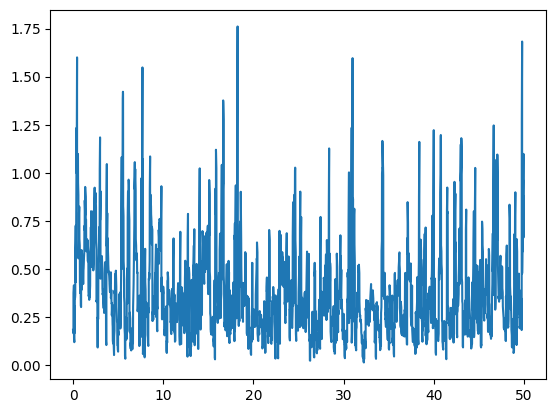

In [5]:
# t1 = np.arange(0, 25, 0.001)

# plt.figure(figsize=(12, 6))
plt.plot(t1, RMSE, label='x')

In [6]:
# trainedModels_withNoise_POMDP_X_noActionLimit_v2